# Defining and Testing websearching tool

In [40]:
import os
import json
from typing import List, Annotated, TypedDict, Optional
from dotenv import load_dotenv
import logging

# langchain components
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage, ToolMessage, HumanMessage
from pydantic import BaseModel, Field

#langgraph components
from langgraph.graph import StateGraph, END
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.prebuilt import ToolNode

#syntaxing
from rich.console import Console
from rich.markdown import Markdown

load_dotenv()

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Agentic Architecture - Tool Use"

for key in ["LANGCHAIN_API_KEY", "TAVILY_API_KEY"]:
    if not os.environ.get(key):
        print(f"{key} not found. Please create a .env file and set it.")

logging.basicConfig(
    level="INFO",
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)

logging.info("Environment variables loaded and tracing is set up.")

2025-12-29 20:18:07,925 - root - INFO - Environment variables loaded and tracing is set up.


In [41]:
# creating and testing the Web Search Tool
search_tool = TavilySearchResults(max_results=2)
search_tool.name = "web_search"
search_tool.description = "A tool that can be used to search the internet for up-to-date information on any topic, including news, events, and current affairs."
tools = [search_tool]

logging.info(f"Tool '{search_tool}' is created with description: '{search_tool.description}' ")

console = Console()

# Let's test the tool directly to see its output format
print("\n Testing the tool directly")
test_query = "What is the current update of the murder of Hudi in Bangladesh?"
test_result = search_tool.invoke({"query": test_query})

console.print(f"[bold green]Query:[/bold green] {test_query}")
console.print("\n[bold green]Result:[/bold green]")
console.print(test_result)

2025-12-29 20:18:07,937 - root - INFO - Tool 'name='web_search' description='A tool that can be used to search the internet for up-to-date information on any topic, including news, events, and current affairs.' max_results=2 api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********'))' is created with description: 'A tool that can be used to search the internet for up-to-date information on any topic, including news, events, and current affairs.' 



 Testing the tool directly


Query: What is the current update of the murder of Hudi in Bangladesh?

Result:

[
    {
        'title': 'Sharif Osman Hadi murder case: Two suspects fled to India, claim ...',
        'url': 
'https://www.thehindu.com/news/international/sharif-osman-hadi-murder-case-two-suspects-fled-to-india-bangladesh-po
lice/article70445934.ece',
        'content': 'He further revealed that a huge amount of money was spent in carrying out the murder, and a 
cheque signed for Tk 218 crore has been seized during the investigation.\n\nPublished - December 28, 2025 03:27 pm 
IST\n\n### Related Topics\n\nIndia-Bangladesh\n/\nBangladesh\n\nReturn to frontpage\nGoogle Play\nApple 
Store\n\n##### The Hindu\n\n##### Contact us\n\n##### Group News Sites\n\n##### Other Products\n\n##### Popular 
Sections\n\n##### Opinion\n\n##### Business\n\n##### Sport\n\n##### Sci-Tech\n\n##### States\n\n##### Cities [...] 
According to him, the government has assigned all law enforcement agencies, including police, Border Guard 
Bangladesh (BGB) and Rapid Action Battalion (RAB), to uncover the masterminds behind the crime.\n\nPolice have also
recovered two pistols allegedly used in the murder, and those are currently being kept at the Criminal 
Investigation Department (CID) for scientific examination.\n\nThe motorcycle used in the attack has been recovered 
by the Detective Branch (DB) police, the BSS added. [...] ## “The suspects, Faisal Karim Masud and Alamgir Sheikh, 
crossed into Meghalaya with the help of local associates,” Additional Police Commissioner (Crime and Operations) of
the Dhaka Metropolitan Police (DMP) said\n\nPublished - December 28, 2025 03:27 pm IST - Dhaka\n\nGoogle Preferred 
Source\nA convoy carrying the body of Sharif Osman Hadi, a student leader, who died after being shot in the head, 
moves along the crowd after the funeral prayer, in Dhaka',
        'score': 0.41905406
    },
    {
        'title': "2 suspects in youth leader Hadi's murder case fled to India, claim ...",
        'url': 
'https://www.tribuneindia.com/news/world/2-suspects-in-youth-leader-hadis-murder-case-fled-to-india-claim-banglades
h-police/',
        'content': "2 suspects in youth leader Hadi's murder case fled to India, claim Bangladesh police ... PTI. 
Dhaka, Updated At : 02:15 PM Dec 28, 2025 IST.",
        'score': 0.27604648
    }
]

# Building the Tool-Using Agent with LangGraph


In [42]:
## Defining the graph state


from langchain.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict

class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

class  AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

logging.info("AgentState TypeDict defined to manage Conversation History")

2025-12-29 20:18:11,872 - root - INFO - AgentState TypeDict defined to manage Conversation History


In [43]:
# Binding tools to the LLM
from langchain_ollama import ChatOllama

llm = ChatOllama(model="llama3.1:8b", temperature=0.2)
llm_with_tools = llm.bind_tools(tools)

# Validate tool binding
try:
    test_response = llm_with_tools.invoke([HumanMessage(content="Test")])
    logging.info("Tool binding validation successful.")
except Exception as e:
    logging.warning(f"Tool binding may not be supported: {e}")

logging.info("LLM has been bound with the provided tools.")




2025-12-29 20:18:20,500 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2025-12-29 20:18:20,722 - root - INFO - Tool binding validation successful.
2025-12-29 20:18:20,722 - root - INFO - LLM has been bound with the provided tools.


In [44]:
# Defining the Agent Nodes
def agent_node(state: AgentState):
    """The primary node that calls the LLM to decide the next action"""
    print("--- AGENT: Thinking... ---")
    print(f"Agent state messages: {state['messages']}")
    try:
        response = llm_with_tools.invoke(state["messages"])
        print(f"Agent response: {response}")
        print(f"Response type: {type(response)}")
        if hasattr(response, 'tool_calls'):
            print(f"Tool calls: {response.tool_calls}")
        return {"messages":[response]}
    except Exception as e:
        logging.error(f"Error in agent_node: {e}")
        error_message = HumanMessage(content=f"Error occurred: {e}")
        return {"messages":[error_message]}  

tool_node = ToolNode(tools)

logging.info("Aget node and Tool node have been defined..")

2025-12-29 20:18:20,732 - root - INFO - Aget node and Tool node have been defined..


In [45]:
# Defining the conditional router
def router_function(state: AgentState):
    """Inspects the agent's last message to decide the next step."""
    print(f"Router state messages: {state['messages']}")
    last_message = state["messages"][-1]
    print(f"Last message: {last_message}")
    print(f"Last message type: {type(last_message)}")
    if hasattr(last_message, 'type'):
        print(f"Message .type: {last_message.type}")
    
    # For LangGraph with bound tools, check if it's an AI message that might contain tool calls
    if hasattr(last_message, 'type') and last_message.type == 'ai':
        # Check for tool_calls in various possible locations
        if (hasattr(last_message, 'tool_calls') and last_message.tool_calls) or \
           (hasattr(last_message, 'additional_kwargs') and 'tool_calls' in last_message.additional_kwargs):
            console.print("--- ROUTER: Decision is to call a tool. ---")
            return "call_tool"
    
    # Default: finish
    console.print("--- ROUTER: Decision is to finish. ---")
    return "__end__"


print("Router function defined.")

Router function defined.


# Assembling and Running the Workflow

2025-12-29 20:18:20,762 - root - INFO - Tool-using agent graph compiled successfully!


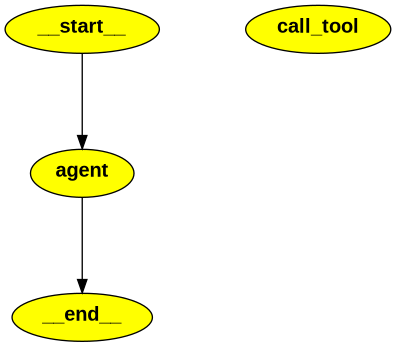

In [46]:
# Building and visualizing the graph
graph_builder = StateGraph(AgentState)

# adding the nodes of the graph
graph_builder.add_node("agent", agent_node)
graph_builder.add_node("call_tool", tool_node)

# building workflow
graph_builder.set_entry_point("agent")
graph_builder.add_conditional_edges(
    'agent',
    router_function,
)
graph_builder.add_conditional_edges("call_tool", lambda state: "agent")

#Compile the graph
tool_agent_app = graph_builder.compile()

logging.info("Tool-using agent graph compiled successfully!")

#Visualize the graph
try:
    from IPython.display import Image, display
    png_image = tool_agent_app.get_graph().draw_png()
    display(Image(png_image))
except Exception as e:
    print(f'Graph visualization field: {e}. Please ensure pygraphviz is installed.')

In [47]:
user_query = "What is current news latest update on Osman Hadi murder in bangladesh?"
initial_input = {"messages": [HumanMessage(content=user_query)]}

for chunk in tool_agent_app.stream(initial_input, stream_mode="values"):
    last_message = chunk["messages"][-1]
    console.print(f"Step Output ({last_message.type}): {last_message.content}")
    if last_message.type == 'ai' and hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        console.print(f"Tool Calls: {last_message.tool_calls}")
    console.print("\n---\n")

console.print("\nTool use workflow completed!")

Step Output (human): What is current news latest update on Osman Hadi murder in bangladesh?

---

--- AGENT: Thinking... ---
Agent state messages: [HumanMessage(content='What is current news latest update on Osman Hadi murder in bangladesh?', additional_kwargs={}, response_metadata={}, id='41b48bc7-4f3e-4b30-b32a-c96c43880a57')]


2025-12-29 20:18:28,934 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Agent response: content='' additional_kwargs={} response_metadata={'model': 'llama3.1:8b', 'created_at': '2025-12-29T14:18:29.189764441Z', 'done': True, 'done_reason': 'stop', 'total_duration': 8361612790, 'load_duration': 199690435, 'prompt_eval_count': 195, 'prompt_eval_duration': 2307196054, 'eval_count': 26, 'eval_duration': 5785512975, 'logprobs': None, 'model_name': 'llama3.1:8b', 'model_provider': 'ollama'} id='lc_run--019b6a79-6b1a-7191-bf83-6d08a22b219c-0' tool_calls=[{'name': 'web_search', 'args': {'query': 'Osman Hadi murder in bangladesh current news'}, 'id': '8d126de0-91dd-493e-b60c-62508c61e288', 'type': 'tool_call'}] usage_metadata={'input_tokens': 195, 'output_tokens': 26, 'total_tokens': 221}
Response type: <class 'langchain_core.messages.ai.AIMessage'>
Tool calls: [{'name': 'web_search', 'args': {'query': 'Osman Hadi murder in bangladesh current news'}, 'id': '8d126de0-91dd-493e-b60c-62508c61e288', 'type': 'tool_call'}]
Router state messages: [HumanMessage(content='Wh

--- ROUTER: Decision is to call a tool. ---

Step Output (ai):

Tool Calls: [{'name': 'web_search', 'args': {'query': 'Osman Hadi murder in bangladesh current news'}, 'id': 
'8d126de0-91dd-493e-b60c-62508c61e288', 'type': 'tool_call'}]

---

Step Output (tool): [{"title": "Sharif Osman Hadi murder case: Two suspects fled to India, claim ...", "url": 
"https://www.thehindu.com/news/international/sharif-osman-hadi-murder-case-two-suspects-fled-to-india-bangladesh-po
lice/article70445934.ece", "content": "A convoy carrying the body of Sharif Osman Hadi, a student leader, who died 
after being shot in the head, moves along the crowd after the funeral prayer, in Dhaka\n| Photo Credit: 
Reuters\n\nTwo primary suspects in the murder of Inquilab Moncho leader Sharif Osman Hadi have fled Bangladesh and 
are believed to be currently in India, a top Dhaka Metropolitan Police officer said on Sunday (December 28, 2025). 
[...] State-run news agency Bangladesh Sangbad Sangstha (BSS) added that Islam said the investigation into Hadi's 
murder is “nearing completion” and “the charge sheet is expected to be submitted within the next seven to ten 
days.”\n\nSo far, 11 people have been arrested in connection with the killing, six of whom have given confessional 
statements before the court under Section 164 of the CrPC, he added.\n\nPolice also said the murder was 
premeditated. [...] According to him, the government has assigned all law enforcement agencies, including police, 
Border Guard Bangladesh (BGB) and Rapid Action Battalion (RAB), to uncover the masterminds behind the 
crime.\n\nPolice have also recovered two pistols allegedly used in the murder, and those are currently being kept 
at the Criminal Investigation Department (CID) for scientific examination.\n\nThe motorcycle used in the attack has
been recovered by the Detective Branch (DB) police, the BSS added.", "score": 0.99991846}, {"title": "Osman Hadi 
murder: Two suspects fled to India, claim Bangladesh ...", "url": 
"https://timesofindia.indiatimes.com/world/south-asia/osman-hadi-murder-two-suspects-fled-to-india-claim-bangladesh
-police-details-so-far/articleshow/126214208.cms", "content": "## Photostories [...] ## Videos [...] interconnected
world.Read More", "score": 0.99911004}]

---

--- AGENT: Thinking... ---
Agent state messages: [HumanMessage(content='What is current news latest update on Osman Hadi murder in bangladesh?', additional_kwargs={}, response_metadata={}, id='41b48bc7-4f3e-4b30-b32a-c96c43880a57'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.1:8b', 'created_at': '2025-12-29T14:18:29.189764441Z', 'done': True, 'done_reason': 'stop', 'total_duration': 8361612790, 'load_duration': 199690435, 'prompt_eval_count': 195, 'prompt_eval_duration': 2307196054, 'eval_count': 26, 'eval_duration': 5785512975, 'logprobs': None, 'model_name': 'llama3.1:8b', 'model_provider': 'ollama'}, id='lc_run--019b6a79-6b1a-7191-bf83-6d08a22b219c-0', tool_calls=[{'name': 'web_search', 'args': {'query': 'Osman Hadi murder in bangladesh current news'}, 'id': '8d126de0-91dd-493e-b60c-62508c61e288', 'type': 'tool_call'}], usage_metadata={'input_tokens': 195, 'output_tokens': 26, 'total_tokens': 221}), ToolMessage(content='[{"title": "Sharif Osman H

2025-12-29 20:18:42,058 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Agent response: content='The current news on the Osman Hadi murder in Bangladesh is that two primary suspects have fled to India, according to the Dhaka Metropolitan Police. The investigation into the murder is nearing completion and a charge sheet is expected to be submitted within the next seven to ten days. So far, 11 people have been arrested in connection with the killing, six of whom have given confessional statements before the court. The police believe that the murder was premeditated and are working to uncover the masterminds behind the crime. Two pistols allegedly used in the murder have been recovered and are being kept at the Criminal Investigation Department for scientific examination.' additional_kwargs={} response_metadata={'model': 'llama3.1:8b', 'created_at': '2025-12-29T14:19:10.803202924Z', 'done': True, 'done_reason': 'stop', 'total_duration': 38089688995, 'load_duration': 206429294, 'prompt_eval_count': 586, 'prompt_eval_duration': 9127507475, 'eval_count': 128, 'e

--- ROUTER: Decision is to finish. ---

Step Output (ai): The current news on the Osman Hadi murder in Bangladesh is that two primary suspects have fled to
India, according to the Dhaka Metropolitan Police. The investigation into the murder is nearing completion and a 
charge sheet is expected to be submitted within the next seven to ten days. So far, 11 people have been arrested in
connection with the killing, six of whom have given confessional statements before the court. The police believe 
that the murder was premeditated and are working to uncover the masterminds behind the crime. Two pistols allegedly
used in the murder have been recovered and are being kept at the Criminal Investigation Department for scientific 
examination.

---

Tool use workflow completed!